In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 4)
import numpy as np
import poppy

In [2]:
RADIUS = 1.0 # meters
WAVELENGTH = 460e-9 # meters
PIXSCALE = 0.01 # arcsec / pix
FOV = 1 # arcsec
NWAVES = 1.0

# Using ZernikeWFE to introduce astigmatism in a PSF

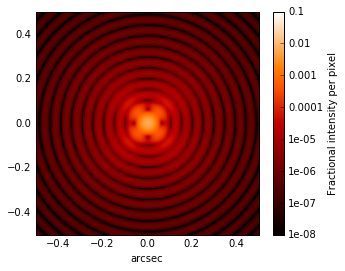

In [3]:
coefficients_sequence = [0, 0, 0, 0, 35e-9]

osys = poppy.OpticalSystem()
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.addPupil(circular_aperture)
thinlens = poppy.ZernikeWFE(radius=RADIUS, coefficients=coefficients_sequence)
osys.addPupil(thinlens)
osys.addDetector(pixelscale=PIXSCALE, fov_arcsec=FOV)

plt.figure(figsize=(5,4))
psf_with_zernikewfe = osys.calcPSF(wavelength=WAVELENGTH)
poppy.display_PSF(psf_with_zernikewfe, title='')
plt.xlabel('arcsec')
plt.savefig('./zernikewfe_astigmatism.png', dpi=150)

# Using ZernikeWFE to analyze a variety of possible PSFs given a WFE budget

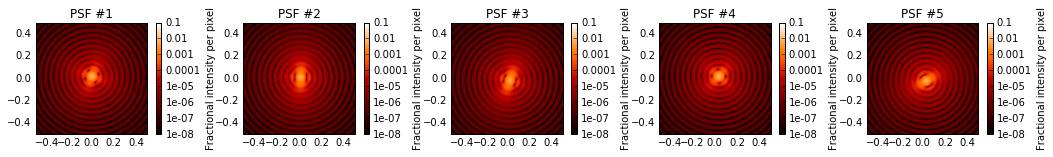

In [4]:
wfe_budget = [0, 100, 100, 50, 36, 36]

def generate_coefficients(wfe_budget):
    coefficients = []
    for term in wfe_budget:
        coefficients.append(
            np.random.uniform(low=-1e-9 * term, high=1e-9 * term)  # convert nm to meters, get value in range
        )
    return coefficients

possible_coefficients = [generate_coefficients(wfe_budget) for i in range(5)]

plt.figure(figsize=(18,2))

for idx, coefficient_set in enumerate(possible_coefficients, start=1):
    plt.subplot(1, 5, idx)

    osys = poppy.OpticalSystem()
    hex_aperture = poppy.CircularAperture(radius=RADIUS)
    osys.addPupil(hex_aperture)
    thinlens = poppy.ZernikeWFE(
        coefficients=coefficient_set,
        radius=RADIUS
    )
    osys.addPupil(thinlens)
    osys.addDetector(pixelscale=PIXSCALE, fov_arcsec=FOV)

    psf = osys.calcPSF(wavelength=WAVELENGTH, display=False)
    poppy.display_PSF(psf, title="PSF #{}".format(idx))

plt.savefig('./zernikewfe_wfe_budget.png', dpi=150, bbox_inches='tight')

# Understanding the normalization employed in POPPY

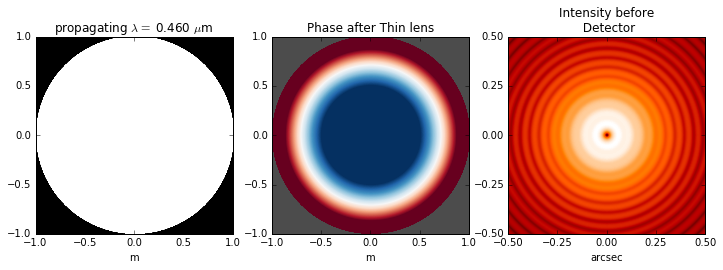

In [5]:
osys = poppy.OpticalSystem()
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.addPupil(circular_aperture)

thinlens = poppy.ThinLens(nwaves=NWAVES, reference_wavelength=WAVELENGTH, radius=RADIUS)
osys.addPupil(thinlens)

osys.addDetector(pixelscale=PIXSCALE, fov_arcsec=FOV)

psf_thinlens = osys.calcPSF(wavelength=WAVELENGTH, display_intermediates=True)

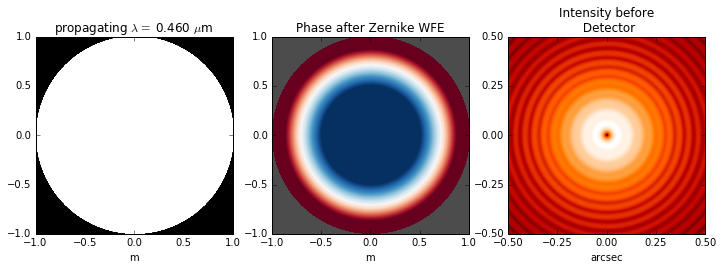

In [6]:
defocus_coefficient = NWAVES * WAVELENGTH / (2 * np.sqrt(3))
coefficients_sequence = [0, 0, 0, defocus_coefficient]

osys = poppy.OpticalSystem()
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.addPupil(circular_aperture)
zernikewfe = poppy.ZernikeWFE(radius=RADIUS, coefficients=coefficients_sequence)
osys.addPupil(zernikewfe)
osys.addDetector(pixelscale=PIXSCALE, fov_arcsec=FOV)

psf_zernikewfe = osys.calcPSF(wavelength=WAVELENGTH, display_intermediates=True)

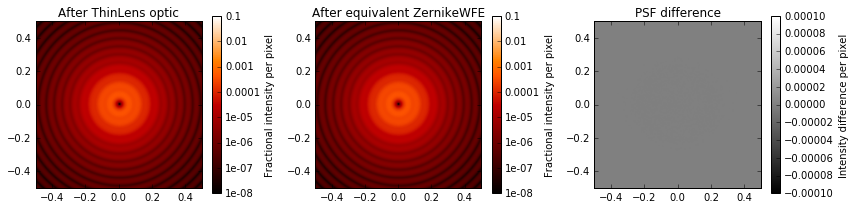

In [7]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
poppy.display_PSF(psf_thinlens, title='After ThinLens optic')
plt.subplot(132)
poppy.display_PSF(psf_zernikewfe, title='After equivalent ZernikeWFE')
plt.subplot(133)
poppy.display_PSF_difference(psf_thinlens, psf_zernikewfe, title='PSF difference')
plt.tight_layout()
plt.savefig('./zernikewfe_understanding_normalization.png', dpi=150)

# ParameterizedWFE: comparing `zernike_basis` and `hexike_basis`

In [8]:
from poppy import zernike

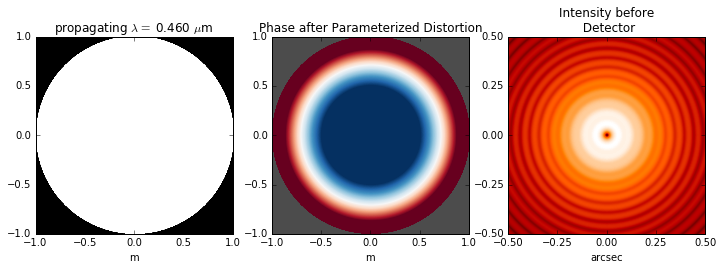

In [9]:
osys = poppy.OpticalSystem()
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.addPupil(circular_aperture)
thinlens = poppy.ParameterizedWFE(radius=RADIUS,
   coefficients=[0, 0, 0, NWAVES * WAVELENGTH / (2 * np.sqrt(3))],
   basis_factory=zernike.zernike_basis   # here's where we specify the basis set
)
osys.addPupil(thinlens)
osys.addDetector(pixelscale=PIXSCALE, fov_arcsec=FOV)

psf_with_zernikewfe = osys.calcPSF(wavelength=WAVELENGTH, display_intermediates=True)

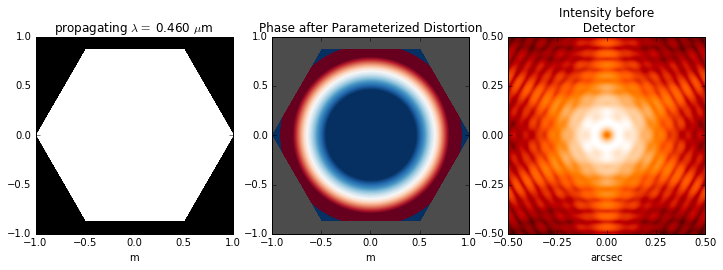

In [10]:
osys = poppy.OpticalSystem()
hex_aperture = poppy.HexagonAperture(side=RADIUS)  # modified to use hexagonal aperture
osys.addPupil(hex_aperture)
thinlens = poppy.ParameterizedWFE(radius=RADIUS,
   coefficients=[0, 0, 0, NWAVES * WAVELENGTH / (2 * np.sqrt(3))],
   basis_factory=zernike.hexike_basis   # now using the 'hexike' basis
)
osys.addPupil(thinlens)
osys.addDetector(pixelscale=PIXSCALE, fov_arcsec=FOV)

psf_with_hexikewfe = osys.calcPSF(wavelength=WAVELENGTH, display_intermediates=True)

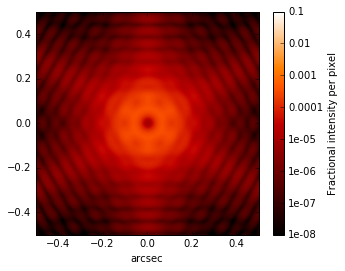

In [11]:
plt.figure(figsize=(5,4))
poppy.display_PSF(psf_with_hexikewfe, title='')
plt.xlabel('arcsec')
plt.savefig('./parameterizedwfe_defocused_hexike.png', dpi=150)